# Modeling with StatsModels

## 1. Ordinary Least Square
- Column Names
- Log Transformation
- Condition Number
- Standard Scaling

# 2. Dimensionality Reduction
- ANOVA
- F-test and Feature Influence

# 3. Outlier
- Cook's Distance

# 4. Regularization
- Lasso

# 5. Diagnosis of Regression
- Residual Normality Test
- Partial Regression Plot

# 6. Cross Validatoin

# 7. Test
- score

In [1]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import warnings
import sys
import os
import datetime
import scipy as sp
import statsmodels.stats.api as sms
import statsmodels.api as sm
from patsy import dmatrix
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('github'))))
import utils.statsmodel_helper as sh
import utils.feature_selection as fs
import utils.preprocessing as pp
import utils.error_calculator as ec

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

df_train_macro = pd.read_csv('../input/train_macro.csv', index_col=0, parse_dates=['timestamp'])
df_test_macro = pd.read_csv('../input/test_macro.csv', index_col=0, parse_dates=['timestamp'])

sys.setrecursionlimit(1500)

degree = 2
skewness_limit = 1
num_of_cooks = 2
num_of_f_test = 10

# 1. Column Names
## Column Names
Replace -, +, :, ~, * in column name with underscore

In [2]:
new_cols = []
for col in  list(df_train_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_train_macro.columns = new_cols

new_cols = []
for col in list(df_test_macro.columns):
    col = col.replace('-', '_').replace('+', '_').replace(':', '_').replace('~', '_').replace('*', '_')
    new_cols.append('_'+col)
df_test_macro.columns = new_cols

categorial_ivs = list(set(df_train_macro.columns.drop('_timestamp')) - set(df_train_macro._get_numeric_data().columns))
numeric_ivs = df_train_macro._get_numeric_data().columns.drop('_price_doc').tolist()

## Log Transformation
Transform data with skewness greater than 1.

In [3]:
features_to_log = []
for f in df_train_macro._get_numeric_data().columns:
    skewness = sp.stats.skew(df_train_macro[f])
    if skewness > skewness_limit:
        features_to_log.append(f)

for col in df_train_macro._get_numeric_data().columns:
    if col != '_price_doc':
        min_val_train = min(df_train_macro[col])
        min_val_test  = min(df_test_macro[col])
        min_val = min(min_val_train, min_val_test)
        if min_val <= 0:
            df_train_macro[col] += (np.abs(min_val) + 0.1)
            df_test_macro[col]  += (np.abs(min_val) + 0.1)
    else:
        min_val_train = min(df_train_macro[col])
        if min_val_train <= 0:
            df_train_macro[col] += (np.abs(min_val_train) + 0.1)

In [4]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=False)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     494.2
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:52:41   Log-Likelihood:                -19185.
No. Observations:               30404   AIC:                         3.846e+04
Df Residuals:                   30358   BIC:                         3.885e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                              -3.832e-05   1.69e-05     -2.265      0.024   -7.15e-05   -5.16e-06
C(_radiation_raion)[T.yes]                                -0.0082      0.003     -2.734      0.006      -0.014      -0.002
C(_thermal_power_plant_raion)[T.yes]                       0.0021      0.002      1.363      0.173      -0.001       0.005
C(_culture_objects_top_25)[T.yes]                         -0.0046      0.001     -4.304      0.000      -0.007      -0.002
C(_incineration_raion)[T.yes]                             -0.0017      0.001     -1.734      0.083      -0.004       0.000
C(_nuclear_reactor_raion)[T.yes]                          -0.0022      0.001     -2.165      0.030      -0.004      -0.000
C(_big_road1_1line)[T.yes]                                -0.0039      0.001     -3.518      0.000      -0.006      -0.002
C(_railroad_terminal_raion)[T.yes]                         0.0009      0.001      1.123      0.261      -0.001       0.003
C(_product_type)[T.OwnerOccupier]                          0.0065      0.002      2.922      0.003       0.002       0.011
C(_railroad_1line)[T.yes]                                 -0.0034      0.001     -4.455      0.000      -0.005      -0.002
C(_oil_chemistry_raion)[T.yes]                            -0.0002      0.001     -0.381      0.703      -0.001       0.001
C(_detention_facility_raion)[T.yes]                        0.0020      0.001      1.383      0.167      -0.001       0.005
C(_ecology)[T.good]                                        0.0014      0.002      0.630      0.529      -0.003       0.006
C(_ecology)[T.no data]                                     0.0009      0.001      1.398      0.162      -0.000       0.002
C(_ecology)[T.poor]                                        0.0063      0.003      1.933      0.053    -8.9e-05       0.013
C(_ecology)[T.satisfactory]                               -0.0077      0.002     -3.903      0.000      -0.012      -0.004
C(_water_1line)[T.yes]                                    -0.0028      0.002     -1.767      0.077      -0.006       0.000
C(_big_market_raion)[T.yes]                               -0.0005      0.001     -0.386      0.699      -0.003       0.002
np.log(_full_sq)                                           0.0118      0.000     52.619      0.000       0.011       0.012
np.log(_life_sq)                                          -0.0125      0.002     -5.781      0.000      -0.017      -0.008
_floor                                                     0.0088      0.002      5.706      0.000       0.006       0.012
np.log(_num_room)                                          0.0046      0.000      9.645      0.000       0.004       0.006
np.log(_

## Condition Number
Large condition number occurs when the scale of data changes significantly due to the unit difference. Scaling can decrease condition number. Multicollinearity can also cause large condition number. We can handle this by reducing dimensionality with variance inflation factor.

## Standard Scaling
Standalize variables by removing the mean and scaling to unit variance.

In [5]:
formula = sh.make_statsmodels_ols_formula(numeric_ivs, categorial_ivs, '_price_doc', log_vs=features_to_log, degree=degree, scale=True)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     60.57
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:55:04   Log-Likelihood:                -18890.
No. Observations:               30404   AIC:                         3.854e+04
Df Residuals:                   30023   BIC:                         4.171e+04
Df Model:                         380                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5694      0.029    528.102      0.000      15.512      15.627
C(_radiation_raion)[T.yes]                                       -0.0467      0.015     -3.070      0.002      -0.076      -0.017
C(_thermal_power_plant_raion)[T.yes]                             -0.0543      0.028     -1.918      0.055      -0.110       0.001
C(_culture_objects_top_25)[T.yes]                                 0.0380      0.029      1.293      0.196      -0.020       0.096
C(_incineration_raion)[T.yes]                                     0.1305      0.043      3.055      0.002       0.047       0.214
C(_nuclear_reactor_raion)[T.yes]                                  0.0149      0.036      0.413      0.680      -0.056       0.086
C(_big_road1_1line)[T.yes]                                       -0.0369      0.020     -1.812      0.070      -0.077       0.003
C(_railroad_terminal_raion)[T.yes]                                0.0719      0.040      1.790      0.073      -0.007       0.151
C(_product_type)[T.OwnerOccupier]                                 0.1442      0.013     10.708      0.000       0.118       0.171
C(_railroad_1line)[T.yes]                                        -0.0690      0.021     -3.362      0.001      -0.109      -0.029
C(_oil_chemistry_raion)[T.yes]                                   -0.0165      0.055     -0.299      0.765      -0.125       0.092
C(_detention_facility_raion)[T.yes]                               0.0182      0.023      0.792      0.428      -0.027       0.063
C(_ecology)[T.good]                                              -0.0304      0.031     -0.990      0.322      -0.090       0.030
C(_ecology)[T.no data]                                            0.0665      0.072      0.930      0.352      -0.074       0.207
C(_ecology)[T.poor]                                              -0.0474      0.021     -2.220      0.026      -0.089      -0.006
C(_ecology)[T.satisfactory]                                      -0.0541      0.029     -1.843      0.065      -0.112       0.003
C(_water_1line)[T.yes]                                           -0.0050      0.013     -0.373      0.709      -0.031       0.021
C(_big_market_raion)[T.yes]                                       0.0517      0.029      1.785      0.074      -0.005       0.109
scale(np.log(_full_sq))                                           0.0091      0.045      0.204      0.839      -0.079       0.097
scale(np.log(_life_sq))                                           0.0224      0.018      1.262      0.207      -0.012       0.057
scale(_floor)                                                     0.0426      0.008      5.19

Scaling did not significantly decrease the condition number.

# 2. Dimensionality Reduction
## ANOVA

In [6]:
anova = sm.stats.anova_lm(result, typ=2)
anova

,sum_sq,df,F,PR(>F)
C(_radiation_raion),1.935487,1.0,9.422105,2.145765e-03
C(_thermal_power_plant_raion),0.756073,1.0,3.680624,5.505771e-02
C(_culture_objects_top_25),0.343303,1.0,1.671224,1.961046e-01
C(_incineration_raion),1.916718,1.0,9.330737,2.255392e-03
C(_nuclear_reactor_raion),0.034975,1.0,0.170263,6.798815e-01
C(_big_road1_1line),0.674207,1.0,3.282092,7.004958e-02
C(_railroad_terminal_raion),0.658321,1.0,3.204760,7.343436e-02
C(_product_type),23.553646,1.0,114.661007,1.043400e-26
C(_railroad_1line),2.322160,1.0,11.304457,7.741776e-04
C(_oil_chemistry_raion),0.018414,1.0,0.089640,7.646374e-01



We can remove features with p-value equal or greater than 0.05 since they have very small influences on the dependent variable

## F-test and Feature Influence

In [7]:
result, sms_vars, formula = fs.by_f_test(df_train_macro, formula, repeat=num_of_f_test)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     313.3
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:00:32   Log-Likelihood:                -19640.
No. Observations:               30404   AIC:                         3.941e+04
Df Residuals:                   30337   BIC:                         3.997e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.5751      0.006   2799.681      0.000      15.564      15.586
C(_radiation_raion)[T.yes]                                       -0.0351      0.008     -4.429      0.000      -0.051      -0.020
C(_incineration_raion)[T.yes]                                     0.0691      0.021      3.337      0.001       0.029       0.110
C(_product_type)[T.OwnerOccupier]                                 0.1321      0.010     12.890      0.000       0.112       0.152
C(_railroad_1line)[T.yes]                                        -0.1210      0.017     -6.968      0.000      -0.155      -0.087
scale(_floor)                                                     0.0400      0.008      4.890      0.000       0.024       0.056
scale(_state)                                                    -0.2166      0.015    -14.187      0.000      -0.246      -0.187
scale(np.log(_area_m))                                            0.4190      0.132      3.165      0.002       0.160       0.678
scale(_school_education_centers_raion)                            0.0327      0.006      5.049      0.000       0.020       0.045
scale(np.log(_university_top_20_raion))                           0.0893      0.021      4.299      0.000       0.049       0.130
scale(np.log(_raion_build_count_with_material_info))            -35.2884      4.010     -8.801      0.000     -43.148     -27.429
scale(np.log(_raion_build_count_with_builddate_info))            35.3539      4.019      8.796      0.000      27.476      43.232
scale(np.log(_build_count_before_1920))                          -0.0231      0.005     -4.232      0.000      -0.034      -0.012
scale(np.log(_kindergarten_km))                                   0.0152      0.007      2.330      0.020       0.002       0.028
scale(np.log(_school_km))                                         0.0520      0.018      2.950      0.003       0.017       0.087
scale(np.log(_kremlin_km))                                        0.2280      0.012     18.344      0.000       0.204       0.252
scale(np.log(_zd_vokzaly_avto_km))                                0.1029      0.016      6.466      0.000       0.072       0.134
scale(np.log(_additional_education_km))                          -0.0328      0.004     -7.625      0.000      -0.041      -0.024
scale(np.log(_preschool_km))                                     -0.0538      0.017     -3.111      0.002      -0.088      -0.020
scale(np.log(_cafe_count_1000_price_high))                        0.0116      0.005      2.322      0.020       0.002       0.021
scale(np.log(_leisure_count_1000))                                0.0508      0.010      5.16

# 3. Outlier
## Cook's Distance
- Find data with large leverage and residual by calculating Cook's distance.

In [8]:
df_train_macro_with_outliers = df_train_macro.copy(deep=True)
df_train_macro, model, result = pp.remove_outliers(df_train_macro, formula, repeat=3)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     3152.
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:01:24   Log-Likelihood:                 14330.
No. Observations:               26684   AIC:                        -2.853e+04
Df Residuals:                   26617   BIC:                        -2.798e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        15.7593      0.002   8104.000      0.000      15.756      15.763
C(_radiation_raion)[T.yes]                                       -0.0226      0.003     -8.517      0.000      -0.028      -0.017
C(_incineration_raion)[T.yes]                                     0.0614      0.007      8.789      0.000       0.048       0.075
C(_product_type)[T.OwnerOccupier]                                -0.0762      0.003    -22.142      0.000      -0.083      -0.069
C(_railroad_1line)[T.yes]                                        -0.1274      0.006    -21.268      0.000      -0.139      -0.116
scale(_floor)                                                     0.0592      0.003     20.873      0.000       0.054       0.065
scale(_state)                                                    -0.1790      0.005    -35.757      0.000      -0.189      -0.169
scale(np.log(_area_m))                                            0.6527      0.046     14.289      0.000       0.563       0.742
scale(_school_education_centers_raion)                            0.0331      0.002     14.907      0.000       0.029       0.037
scale(np.log(_university_top_20_raion))                           0.0144      0.008      1.916      0.055      -0.000       0.029
scale(np.log(_raion_build_count_with_material_info))            -27.8287      1.369    -20.331      0.000     -30.512     -25.146
scale(np.log(_raion_build_count_with_builddate_info))            27.8590      1.372     20.303      0.000      25.169      30.549
scale(np.log(_build_count_before_1920))                          -0.0198      0.002    -11.046      0.000      -0.023      -0.016
scale(np.log(_kindergarten_km))                                   0.0135      0.002      6.143      0.000       0.009       0.018
scale(np.log(_school_km))                                         0.0274      0.006      4.372      0.000       0.015       0.040
scale(np.log(_kremlin_km))                                        0.1784      0.005     39.115      0.000       0.170       0.187
scale(np.log(_zd_vokzaly_avto_km))                                0.0666      0.007      9.971      0.000       0.054       0.080
scale(np.log(_additional_education_km))                          -0.0109      0.001     -7.508      0.000      -0.014      -0.008
scale(np.log(_preschool_km))                                     -0.0245      0.006     -3.977      0.000      -0.037      -0.012
scale(np.log(_cafe_count_1000_price_high))                        0.0058      0.002      3.373      0.001       0.002       0.009
scale(np.log(_leisure_count_1000))                                0.0291      0.004      7.91

# 4. Regularization
## Lasso
Find variables with zero coefficient when Lasso regularization is applied.

In [9]:
result_lasso = model.fit_regularized(alpha=0.001, L1_wt=1)

Let's remove features with zero coefficient to reduce dimensionality.

In [10]:
sms_vars = []
for idx, coef in enumerate(result_lasso.params):
    if coef ==0:
        continue
    feature = result_lasso.params.index[idx]
    if feature == 'Intercept':
        continue
    startDelPos = feature.find('[')
    endDelPos = feature.find(']')
    feature = feature.replace(feature[startDelPos:endDelPos+1], '')
    sms_vars.append(feature)

In [11]:
formula = 'np.log(_price_doc) ~ ' + " + ".join(sms_vars)
model = sm.OLS.from_formula(formula, data=df_train_macro)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(_price_doc)   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     6306.
Date:                Mon, 16 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:01:41   Log-Likelihood:                 17503.
No. Observations:               25000   AIC:                        -3.492e+04
Df Residuals:                   24959   BIC:                        -3.459e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                     15.7634      0.002   9491.904      0.000      15.760      15.767
C(_radiation_raion)[T.yes]                                    -0.0099      0.002     -4.662      0.000      -0.014      -0.006
C(_product_type)[T.OwnerOccupier]                             -0.1016      0.003    -33.558      0.000      -0.107      -0.096
C(_railroad_1line)[T.yes]                                     -0.1560      0.005    -28.924      0.000      -0.167      -0.145
scale(_floor)                                                  0.0567      0.003     22.396      0.000       0.052       0.062
scale(_state)                                                 -0.2009      0.004    -45.414      0.000      -0.210      -0.192
scale(np.log(_area_m))                                        -0.0017      0.001     -1.166      0.244      -0.005       0.001
scale(_school_education_centers_raion)                         0.0400      0.002     25.581      0.000       0.037       0.043
scale(np.log(_university_top_20_raion))                        0.0036      0.001      3.229      0.001       0.001       0.006
scale(np.log(_raion_build_count_with_material_info))           0.0121      0.001     10.360      0.000       0.010       0.014
scale(np.log(_build_count_before_1920))                       -0.0131      0.001    -10.886      0.000      -0.016      -0.011
scale(np.log(_kindergarten_km))                                0.0004      0.001      0.369      0.712      -0.002       0.003
scale(np.log(_kremlin_km))                                     0.0932      0.003     34.366      0.000       0.088       0.099
scale(np.log(_zd_vokzaly_avto_km))                            -0.0409      0.002    -19.265      0.000      -0.045      -0.037
scale(np.log(_cafe_count_1000_price_high))                     0.0055      0.002      3.607      0.000       0.002       0.008
scale(np.log(_leisure_count_1000))                             0.0045      0.001      4.098      0.000       0.002       0.007
scale(np.log(_sport_count_2000))                               0.0393      0.002     22.177      0.000       0.036       0.043
scale(np.log(_cafe_count_3000_price_1000))                     0.0582      0.002     25.793      0.000       0.054       0.063
scale(np.log(_office_sqm_5000))                                0.0104      0.001      8.026      0.000       0.008       0.013
scale(np.log(_cafe_count_5000_price_high))                     0.0189      0.002     11.865      0.000       0.016       0.022
scale(np.log(_leisure_count_5000))                             0.0173      0.002      8.840      0.000       0.013       0.021
scale(_market_count_5000)          

# 5. Diagnosis of Regression
## Residual Normality Test

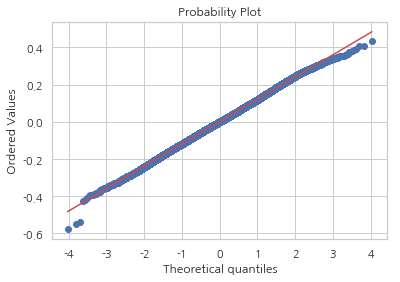

In [12]:
# outlier remove result 
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [13]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  0.481
P-value     :  0.786


# Partial Regression Plot
Let's visualize the influence of a single independent variable.

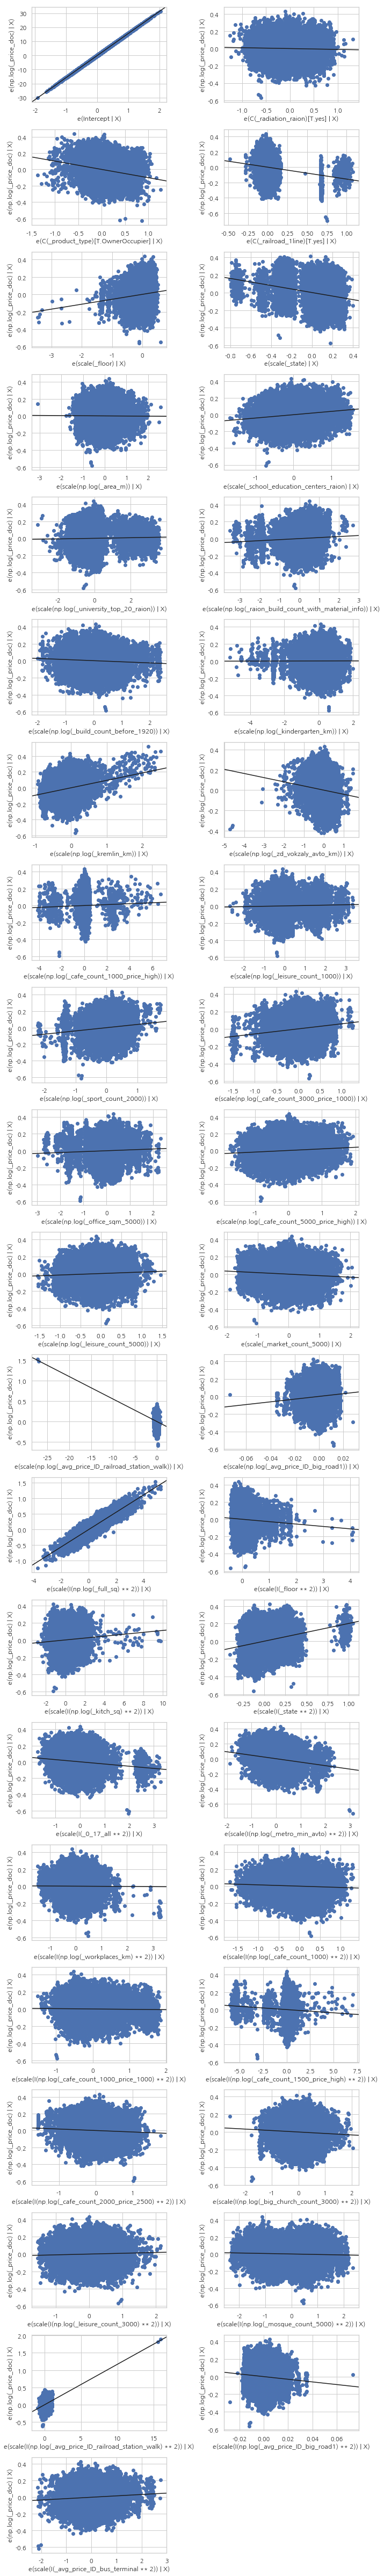

In [14]:
fig = plt.figure(figsize=(10,70))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

# 6. Cross Validation

In [15]:
dm = dmatrix(" + ".join(sms_vars) + ' + np.log(_price_doc)', df_train_macro_with_outliers, return_type="dataframe")
X = dm[dm.columns.drop(['np.log(_price_doc)'])]
y = dm['np.log(_price_doc)']
cv = cv = KFold(n_splits=1000, shuffle=True, random_state=0)
r2s = cross_val_score(SMWrapper(sm.OLS), X, y, scoring='r2', cv=cv)
r2s.mean()

0.38416264080373247

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  3.,
         2.,  4.,  3.,  2.,  1.,  2.,  2.,  3.,  5.,  4.,  6., 12.,  7.,
        10., 10., 15., 13.,  9., 13., 11., 16., 19., 12., 13., 20., 22.,
        28., 20., 33., 23., 33., 31., 44., 37., 28., 37., 27., 26., 27.,
        33., 32., 28., 27., 27., 28., 24., 17., 20., 19., 12., 15., 20.,
        14.,  7., 10.,  1., 10.,  4.,  5.,  3.,  2.]),
 array([-0.85016519, -0.83312593, -0.81608666, -0.7990474 , -0.78200814,
        -0.76496887, -0.74792961, -0.73089035, -0.71385108, -0.69681182,
        -0.67977255, -0.66273329, -0.64569403, -0.62865476, -0.6116155 ,
        -0.59457624, -0.57753697, -0.56049771, -0.54345844, -0.52641918,
        -0.50937992, -0.49234065, -0.47530139, -0.45826213, -0.44122286,
        -0.4241836 , -0.40714433, -0.39010507, -0.37306581, -0.356026

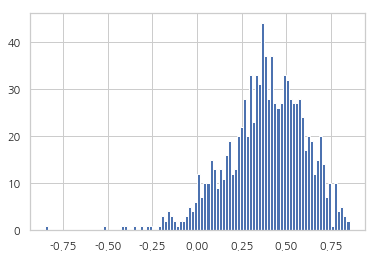

In [16]:
plt.hist(r2s, bins=100)

In [17]:
y_pred = np.exp(result.predict(df_test_macro))
y_pred = y_pred.to_frame('price_doc')
y_pred.to_csv('../submissions/stats_models_{}.csv'.format(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')), header=True, index=True)

## Score

RMSLE : 0.33945

In [18]:
for col in df_train_macro_with_outliers.columns:
    df_train_macro_with_outliers.rename(columns={col:col[1:]}, inplace=True)
for col in df_train_macro.columns:
    df_train_macro.rename(columns={col:col[1:]}, inplace=True)
df_train_macro_with_outliers.to_csv('../input/train_macro_with_outliers.csv', header=True, index=True)
df_train_macro.to_csv('../input/train_macro_without_outliers.csv', header=True, index=True)